## load data

In [1]:
import sys
sys.path.append(r'E:\Users\lzk26\Desktop\YoloV8-Pose-Keypoint-Classification-master')  # 添加上级目录到搜索路径


from models.exception_detect import Autoencoder

In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# 加载数据
df_test = pd.read_csv('../datasets/test/combined_cpr_nocpr_new.csv')

features = df_test.drop(['image_name','label'], axis=1)
labels = df_test['label']
# 假设labels已经是一个包含"CPR"和"NonCPR"字符串的Pandas Series
binary_labels = labels.map({'CPR': 1, 'Non-CPR': 0}).values


# 归一化特征
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# 转换为PyTorch张量
features_tensor = torch.FloatTensor(features_normalized)


In [4]:
df_test.head()

,image_name,label,x1,y1,z1,x2,y2,z2,x3,y3,...,z30,x31,y31,z31,x32,y32,z32,x33,y33,z33
0,example.jpg,CPR,0.542831,0.276556,-0.221800,0.530004,0.260702,-0.193974,0.528444,0.259881,...,0.619372,0.297546,0.869596,0.200851,0.336462,0.908028,0.574604,0.320529,0.917581,0.148446
1,example.jpg,CPR,0.544486,0.276279,-0.153919,0.533579,0.259929,-0.125839,0.531753,0.259232,...,0.554446,0.291620,0.857704,0.044749,0.266579,0.905721,0.545901,0.237856,0.910119,0.050000
2,example.jpg,CPR,0.547902,0.273676,-0.165565,0.537856,0.255792,-0.137100,0.536201,0.255211,...,0.592064,0.291767,0.851158,0.043375,0.291420,0.903764,0.589067,0.246542,0.905335,0.033048
3,example.jpg,CPR,0.553824,0.271759,-0.142937,0.544993,0.252545,-0.114899,0.543214,0.251941,...,0.559125,0.291855,0.848624,0.022375,0.296879,0.901034,0.556046,0.243603,0.900863,0.024479
4,example.jpg,CPR,0.554181,0.265966,-0.165957,0.544963,0.247210,-0.138330,0.543265,0.246771,...,0.584841,0.289977,0.839544,0.042476,0.263378,0.893754,0.582978,0.231888,0.897309,0.040621


## load model

In [5]:
hidden_size = 256
PATH_SAVE = '../models/pose_classification.pt'


model_inference = Autoencoder(
    input_size=features.shape[1], 
    hidden_size=hidden_size
)

# 加载模型状态
model_inference.load_state_dict(
    torch.load(PATH_SAVE, map_location=device)
)


model_inference.eval()  # 设置为评估模式

with torch.no_grad():
    reconstructed = model_inference(features_tensor)
    reconstruction_error = ((features_tensor - reconstructed) ** 2).mean(1)


## 评估模型

In [6]:
# 设定阈值
threshold = 0.04
# 将重构误差大于阈值的样本视为异常（非CPR）
predictions = (reconstruction_error <= threshold).numpy().astype(int)

# 计算性能指标
from sklearn.metrics import classification_report
print(classification_report(binary_labels,predictions, target_names=['NonCPR', 'CPR']))


              precision    recall  f1-score   support

      NonCPR       0.82      0.97      0.89       238
         CPR       0.97      0.84      0.90       321

    accuracy                           0.90       559
   macro avg       0.90      0.91      0.90       559
weighted avg       0.91      0.90      0.90       559


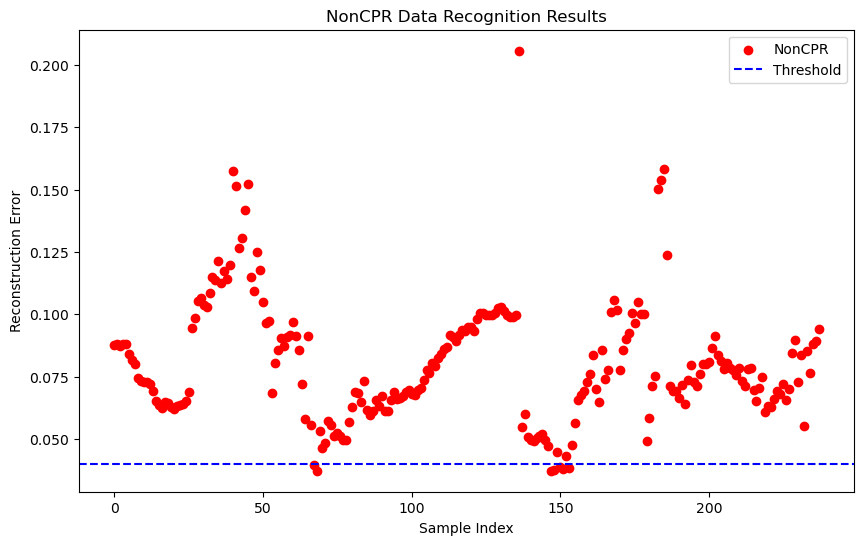

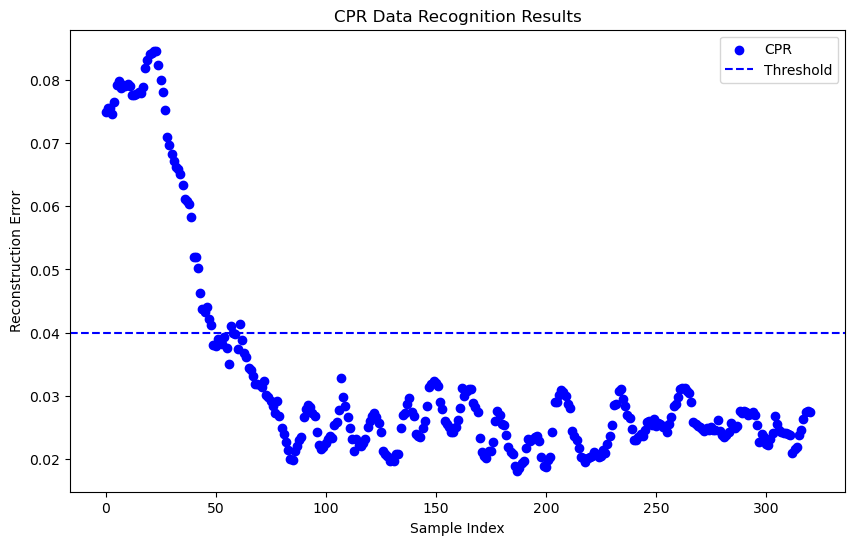

In [7]:
# 假设reconstruction_error是一个numpy数组
# 分别获取NonCPR和CPR的重构误差
noncpr_errors = reconstruction_error[binary_labels == 0]
cpr_errors = reconstruction_error[binary_labels == 1]

# 绘制NonCPR的数据识别结果散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(noncpr_errors)), noncpr_errors, color='red', label='NonCPR')
plt.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
plt.title('NonCPR Data Recognition Results')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# 绘制CPR的数据识别结果散点图
plt.figure(figsize=(10, 6))
plt.scatter(range(len(cpr_errors)), cpr_errors, color='blue', label='CPR')
plt.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
plt.title('CPR Data Recognition Results')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()